In [1]:
# n_estimators:[100,150,200,250,300,350,400]：决策树的个数，越多越好，但是性能就会越差，至少100左右（具体数字忘记从哪里来的了）可以达到可接受的性能和误差率。 
# criterion: ["gini","entropy"](default=”gini”)是计算属性的gini(基尼不纯度)还是entropy(信息增益)，来选择最合适的节点。
# max_features: ["auto","sqrt","log2","None"]
# traindata_rate=[0.7,0.8,0.9]
n_estimators=[100,150,200,250,300,350,400]
criterion=["gini","entropy"]
max_features=["auto","sqrt","log2"]
traindata_rate=[0.7,0.8,0.9]

# Fitness Function

In [3]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, ensemble, preprocessing, metrics

def create_chromsom_value_X(filename):
    chromosom_value_X=[]
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    for index in range(0,len(col_list)-1):
        chromosom_value_X.append([0,1])
    return chromosom_value_X

def create_chromsom_value_all(filename):
    chromosom_value=create_chromsom_value_X(filename)
    chromosom_value.append(n_estimators)
    chromosom_value.append(criterion)
    chromosom_value.append(max_features)
    chromosom_value.append(traindata_rate)
    return chromosom_value

def create_x_tmp(ETF_train,col_list,chromosome):
    x_tmp=[]
    for index in range(0,len(col_list)-1):
        if chromosome[index] ==1:
            x_tmp.append(ETF_train[col_list[index]])
    return x_tmp

def random_forest_model(filename,chromsome):
    # 載入資料
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    n_estimators_c=chromsome[len(col_list)-1]
    criterion_c=chromsome[len(col_list)+0]
    max_features_c=chromsome[len(col_list)+1]
    traindata_rate=chromsome[len(col_list)+2]

    # 建立訓練與測試資料
    x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
    ETF_X = pd.DataFrame(x_tmp).T
    ETF_Y = ETF_train["Y"]

    train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
    test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
    train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
    test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

    # 建立 random forest 模型
    forest = ensemble.RandomForestClassifier(n_estimators = n_estimators_c,criterion=criterion_c,max_features=max_features_c)
    forest_fit = forest.fit(train_X, train_Y)

    # 預測
    test_y_predicted = forest.predict(test_X)

    # 績效
    accuracy = metrics.accuracy_score(test_Y, test_y_predicted)
    return accuracy


# GA Function

In [4]:
filename='featured/0051_01.csv'
chromosom_value=create_chromsom_value_all(filename)

import random
def createrandomList(create_number,category):
    list_random = [ random.randint(0,category) for i in range(create_number)]
    return(list_random)

#init create population chromosome(100)--function input：filename & population, output：population_list 
def create_population(population):
    population_list=[]
    for popu in range(population):
        chromosome_create=[]
        for index in chromosom_value:
            chromosome_create.append(index[createrandomList(1,len(index)-1)[0]]) #從chromosom_value隨機產生一個值塞到
        population_list.append(chromosome_create)
    return population_list

def cross(cross_rate,chromosome_1,chromosome_2):
    random_rate=random.random()
    if(random_rate>cross_rate):
        point_1=random.randint(0,len(chromosome_1)-1)
        point_2=random.randint(0,len(chromosome_1)-1)

        while(point_1>=point_2):
            point_1=random.randint(0,len(chromosome_1)-1)
            point_2=random.randint(0,len(chromosome_1)-1)

#         print("cross_point1: "+str(point_1))
#         print("cross_point2: "+str(point_2))
#         print("cross_len_chromosome_1= "+str(len(chromosome_1)))
#         print("cross_len_chromosome_2= "+str(len(chromosome_2)))

        tmp=0
        for index in range(point_1,point_2+1):
            tmp=chromosome_1[index]
            chromosome_1[index]=chromosome_2[index]
            chromosome_2[index]=tmp
    return chromosome_1

def mutation(mutation_rate,chromosome):
    random_rate=random.random()
    if(random_rate>mutation_rate):
#         print("mutation_start")
        point_1=random.randint(0,len(chromosome)-1)#產生二個隨機point1 & point2 為了到時候mutation
        point_2=random.randint(0,len(chromosome)-1)
        while(point_1==point_2):#如果point1 point2 一樣要重新產生
            point_1=random.randint(0,len(chromosome)-1)
            point_2=random.randint(0,len(chromosome)-1)
#         print("mu_point1= "+str(point_1))
#         print("mu_point2= "+str(point_2))

        tmp=chromosome[point_1]#改變染色體中第point1的值，如果產生的新值與舊的一樣要再重新產生
        #chromosome[point_1]值等於chromosom_value裡面隨機產生的一個值createrandomList(1,len(chromosom_value[point_1])-1)[0]
        chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]#
        while(tmp==chromosome[point_1]):
            chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]

        tmp_2=chromosome[point_2]#改變染色體中第point2的值，如果產生的新值與舊的一樣要再重新產生
        chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
        while(tmp_2==chromosome[point_2]):
            chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
    return chromosome

def calculateY_rank(rank_number,population_list,filename):
    result_all_x_fitness=[]#記錄所有population與產生的y
    best_result=[]#記錄最好的population&y

    for index in population_list:
        fitness_value=random_forest_model(filename,index)#calculate fintness_value
        result_all_x_fitness.append([fitness_value,index])
    
    result_rank=[]#record before rank"s x & fitness_value
    for index in range(0,rank_number):
        result_rank.append(sorted(result_all_x_fitness,reverse=True)[index])#sort:big->small
    best_result=result_rank[0]
    
    x_final=[]#記錄前十五名的染色體
    for index in result_rank:
        x_final.append(index[1])
    return [x_final,best_result]

#產生新的X(上一代最好的前15個交配+突變產生新的15個+隨機產生85個新的x)--function
def create_new_x(rank_number,population,cross_rate,mutation_rate,x_final):
    new_x=[]
    #先把前15名的染色體做交配&突變->產生新15個染色體
    for index in range(0,rank_number):
        other_ch=createrandomList(1,rank_number-1)[0]
        while(index==other_ch):
            other_ch=createrandomList(1,rank_number-1)[0] #變矩陣要減1 if index= other_ch -> create other_ch again
#         print("i_th chromosome: "+str(index))
#         print("other_random_chromosome: "+str(other_ch))
        cross_result=cross(cross_rate,x_final[index],x_final[other_ch])
        new_x.append(mutation(mutation_rate,cross_result))

    #隨機產生第16~100的染色體
    for index in range(0,population-rank_number):
        new_x.append(create_population(1)[0])
    return new_x

In [5]:
#GA + regression ->main
print(filename)
import datetime
#init parameter
#filename='0051_random.csv'
iteration=60
iteration_now=0
population=100
rank_number=10

cross_rate=0.3
mutation_rate=0.3

y_target=20000#fitnessvalue的目標，到達就停止迭代
y_best=-1#目前為止(所有迭代中)最好的fitnessvalue
y_now=-1#當前此迭代中最好的fitnessvalue
x_best=[]
y_best_everyiteration=[]

population_list=create_population(population)#產生初始母體染色體

Totalstarttime=datetime.datetime.now()
print("Start GA: "+str(Totalstarttime))
while(not(iteration_now>=iteration or y_best>y_target)):
    iteration_now=iteration_now+1
    print("\niteration_now= "+str(iteration_now))
    Y=calculateY_rank(rank_number,population_list,filename) #return X_final(前15名的染色體) & best_result(此代最好的fitness跟染色體)
    y_now=Y[1][0]
    print("y_now= "+str(y_now))
    if y_now>y_best:
        y_best=y_now
        x_best=Y[1][1]
        #print("x_best= "+str(x_best))
    print("y_best= "+str(y_best))
    y_best_everyiteration.append(y_best)
    population_list=create_new_x(rank_number,population,cross_rate,mutation_rate,Y[0])

print("iteration_now= "+str(iteration_now))
print("y_best= "+str(y_best))
print("x_best= "+str(x_best))

print("GA's end time is "+str(datetime.datetime.now()))
print("All time spends:  "+str(datetime.datetime.now()-Totalstarttime))


featured/0051_01.csv
Start GA: 2018-05-29 12:50:14.003430

iteration_now= 1
y_now= 0.555555555556
y_best= 0.555555555556
i_th chromosome: 0
other_random_chromosome: 6
cross_point1: 19
cross_point2: 53
mutation_start
mu_point1= 39
mu_point2= 29
i_th chromosome: 1
other_random_chromosome: 9
cross_point1: 9
cross_point2: 29
mutation_start
mu_point1= 53
mu_point2= 66
i_th chromosome: 2
other_random_chromosome: 8
cross_point1: 33
cross_point2: 53
mutation_start
mu_point1= 47
mu_point2= 1
i_th chromosome: 3
other_random_chromosome: 1
cross_point1: 10
cross_point2: 69
i_th chromosome: 4
other_random_chromosome: 9
cross_point1: 36
cross_point2: 66
mutation_start
mu_point1= 48
mu_point2= 1
i_th chromosome: 5
other_random_chromosome: 0
cross_point1: 10
cross_point2: 57
mutation_start
mu_point1= 10
mu_point2= 8
i_th chromosome: 6
other_random_chromosome: 0
mutation_start
mu_point1= 75
mu_point2= 48
i_th chromosome: 7
other_random_chromosome: 3
cross_point1: 41
cross_point2: 62
mutation_start
mu_p

y_now= 0.603174603175
y_best= 0.603174603175
i_th chromosome: 0
other_random_chromosome: 7
cross_point1: 28
cross_point2: 77
i_th chromosome: 1
other_random_chromosome: 4
cross_point1: 24
cross_point2: 45
mutation_start
mu_point1= 64
mu_point2= 6
i_th chromosome: 2
other_random_chromosome: 4
mutation_start
mu_point1= 3
mu_point2= 21
i_th chromosome: 3
other_random_chromosome: 8
cross_point1: 8
cross_point2: 13
mutation_start
mu_point1= 44
mu_point2= 22
i_th chromosome: 4
other_random_chromosome: 8
cross_point1: 63
cross_point2: 69
i_th chromosome: 5
other_random_chromosome: 0
cross_point1: 34
cross_point2: 57
mutation_start
mu_point1= 29
mu_point2= 65
i_th chromosome: 6
other_random_chromosome: 3
mutation_start
mu_point1= 75
mu_point2= 6
i_th chromosome: 7
other_random_chromosome: 2
cross_point1: 32
cross_point2: 34
mutation_start
mu_point1= 49
mu_point2= 25
i_th chromosome: 8
other_random_chromosome: 3
cross_point1: 58
cross_point2: 67
mutation_start
mu_point1= 22
mu_point2= 66
i_th c

y_now= 0.595238095238
y_best= 0.619047619048
i_th chromosome: 0
other_random_chromosome: 7
cross_point1: 6
cross_point2: 33
i_th chromosome: 1
other_random_chromosome: 3
cross_point1: 0
cross_point2: 46
mutation_start
mu_point1= 59
mu_point2= 74
i_th chromosome: 2
other_random_chromosome: 8
cross_point1: 51
cross_point2: 68
i_th chromosome: 3
other_random_chromosome: 4
mutation_start
mu_point1= 71
mu_point2= 31
i_th chromosome: 4
other_random_chromosome: 3
mutation_start
mu_point1= 21
mu_point2= 41
i_th chromosome: 5
other_random_chromosome: 3
cross_point1: 3
cross_point2: 67
mutation_start
mu_point1= 68
mu_point2= 46
i_th chromosome: 6
other_random_chromosome: 3
cross_point1: 38
cross_point2: 69
i_th chromosome: 7
other_random_chromosome: 9
cross_point1: 16
cross_point2: 34
i_th chromosome: 8
other_random_chromosome: 9
cross_point1: 14
cross_point2: 47
i_th chromosome: 9
other_random_chromosome: 2
cross_point1: 7
cross_point2: 26
mutation_start
mu_point1= 65
mu_point2= 0

iteration_no

y_now= 0.611111111111
y_best= 0.619047619048
i_th chromosome: 0
other_random_chromosome: 8
cross_point1: 6
cross_point2: 55
mutation_start
mu_point1= 63
mu_point2= 20
i_th chromosome: 1
other_random_chromosome: 9
mutation_start
mu_point1= 33
mu_point2= 9
i_th chromosome: 2
other_random_chromosome: 0
cross_point1: 37
cross_point2: 52
mutation_start
mu_point1= 72
mu_point2= 19
i_th chromosome: 3
other_random_chromosome: 7
mutation_start
mu_point1= 41
mu_point2= 73
i_th chromosome: 4
other_random_chromosome: 9
mutation_start
mu_point1= 72
mu_point2= 62
i_th chromosome: 5
other_random_chromosome: 1
cross_point1: 1
cross_point2: 54
mutation_start
mu_point1= 24
mu_point2= 68
i_th chromosome: 6
other_random_chromosome: 9
cross_point1: 7
cross_point2: 44
mutation_start
mu_point1= 20
mu_point2= 51
i_th chromosome: 7
other_random_chromosome: 5
cross_point1: 16
cross_point2: 41
i_th chromosome: 8
other_random_chromosome: 7
cross_point1: 0
cross_point2: 30
mutation_start
mu_point1= 59
mu_point2= 5

y_now= 0.603174603175
y_best= 0.619047619048
i_th chromosome: 0
other_random_chromosome: 4
mutation_start
mu_point1= 39
mu_point2= 17
i_th chromosome: 1
other_random_chromosome: 0
cross_point1: 39
cross_point2: 44
mutation_start
mu_point1= 51
mu_point2= 23
i_th chromosome: 2
other_random_chromosome: 6
cross_point1: 61
cross_point2: 76
mutation_start
mu_point1= 62
mu_point2= 75
i_th chromosome: 3
other_random_chromosome: 2
cross_point1: 24
cross_point2: 61
mutation_start
mu_point1= 9
mu_point2= 45
i_th chromosome: 4
other_random_chromosome: 5
cross_point1: 41
cross_point2: 56
i_th chromosome: 5
other_random_chromosome: 9
cross_point1: 18
cross_point2: 46
i_th chromosome: 6
other_random_chromosome: 0
cross_point1: 24
cross_point2: 73
mutation_start
mu_point1= 36
mu_point2= 29
i_th chromosome: 7
other_random_chromosome: 1
i_th chromosome: 8
other_random_chromosome: 9
i_th chromosome: 9
other_random_chromosome: 2
mutation_start
mu_point1= 18
mu_point2= 60

iteration_now= 34
y_now= 0.619047

y_now= 0.603174603175
y_best= 0.619047619048
i_th chromosome: 0
other_random_chromosome: 3
cross_point1: 23
cross_point2: 78
mutation_start
mu_point1= 54
mu_point2= 34
i_th chromosome: 1
other_random_chromosome: 7
cross_point1: 23
cross_point2: 29
mutation_start
mu_point1= 20
mu_point2= 35
i_th chromosome: 2
other_random_chromosome: 6
cross_point1: 61
cross_point2: 72
mutation_start
mu_point1= 20
mu_point2= 14
i_th chromosome: 3
other_random_chromosome: 0
i_th chromosome: 4
other_random_chromosome: 6
cross_point1: 34
cross_point2: 59
i_th chromosome: 5
other_random_chromosome: 8
cross_point1: 32
cross_point2: 78
mutation_start
mu_point1= 1
mu_point2= 60
i_th chromosome: 6
other_random_chromosome: 5
cross_point1: 76
cross_point2: 78
mutation_start
mu_point1= 63
mu_point2= 50
i_th chromosome: 7
other_random_chromosome: 2
i_th chromosome: 8
other_random_chromosome: 2
cross_point1: 25
cross_point2: 65
mutation_start
mu_point1= 11
mu_point2= 55
i_th chromosome: 9
other_random_chromosome: 0


y_now= 0.571428571429
y_best= 0.619047619048
i_th chromosome: 0
other_random_chromosome: 3
cross_point1: 46
cross_point2: 79
i_th chromosome: 1
other_random_chromosome: 0
cross_point1: 3
cross_point2: 31
mutation_start
mu_point1= 24
mu_point2= 13
i_th chromosome: 2
other_random_chromosome: 8
cross_point1: 39
cross_point2: 51
mutation_start
mu_point1= 26
mu_point2= 51
i_th chromosome: 3
other_random_chromosome: 6
i_th chromosome: 4
other_random_chromosome: 5
i_th chromosome: 5
other_random_chromosome: 2
mutation_start
mu_point1= 21
mu_point2= 4
i_th chromosome: 6
other_random_chromosome: 4
cross_point1: 21
cross_point2: 29
mutation_start
mu_point1= 12
mu_point2= 25
i_th chromosome: 7
other_random_chromosome: 9
cross_point1: 68
cross_point2: 74
mutation_start
mu_point1= 15
mu_point2= 65
i_th chromosome: 8
other_random_chromosome: 7
cross_point1: 27
cross_point2: 49
mutation_start
mu_point1= 16
mu_point2= 45
i_th chromosome: 9
other_random_chromosome: 5
cross_point1: 12
cross_point2: 66
m

y_now= 0.571428571429
y_best= 0.650793650794
i_th chromosome: 0
other_random_chromosome: 4
mutation_start
mu_point1= 44
mu_point2= 28
i_th chromosome: 1
other_random_chromosome: 6
cross_point1: 32
cross_point2: 78
mutation_start
mu_point1= 62
mu_point2= 14
i_th chromosome: 2
other_random_chromosome: 4
cross_point1: 25
cross_point2: 28
i_th chromosome: 3
other_random_chromosome: 5
cross_point1: 2
cross_point2: 45
mutation_start
mu_point1= 52
mu_point2= 56
i_th chromosome: 4
other_random_chromosome: 3
cross_point1: 19
cross_point2: 46
mutation_start
mu_point1= 2
mu_point2= 39
i_th chromosome: 5
other_random_chromosome: 2
mutation_start
mu_point1= 30
mu_point2= 8
i_th chromosome: 6
other_random_chromosome: 1
cross_point1: 1
cross_point2: 44
i_th chromosome: 7
other_random_chromosome: 8
i_th chromosome: 8
other_random_chromosome: 3
cross_point1: 51
cross_point2: 64
mutation_start
mu_point1= 9
mu_point2= 7
i_th chromosome: 9
other_random_chromosome: 0
mutation_start
mu_point1= 3
mu_point2= 

# 畫GA迭代圖

featured/0051_01.csv


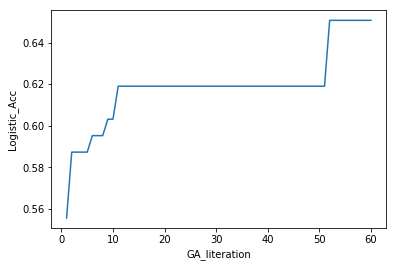

In [7]:
print(filename)
import matplotlib.pyplot as plt
plt.plot(list(range(1,iteration+1)),y_best_everyiteration)
plt.xlabel("GA_literation")
plt.ylabel("Logistic_Acc")
plt.show()

# 畫決策樹圖

In [8]:
print(filename)
#X_best=x_best= [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 100, 'entropy', 'auto', 0.9]
print(x_best)
fitness_value=random_forest_model(filename,x_best)
print(fitness_value)

featured/0051_01.csv
[1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 400, 'entropy', 'log2', 0.9]
0.555555555556


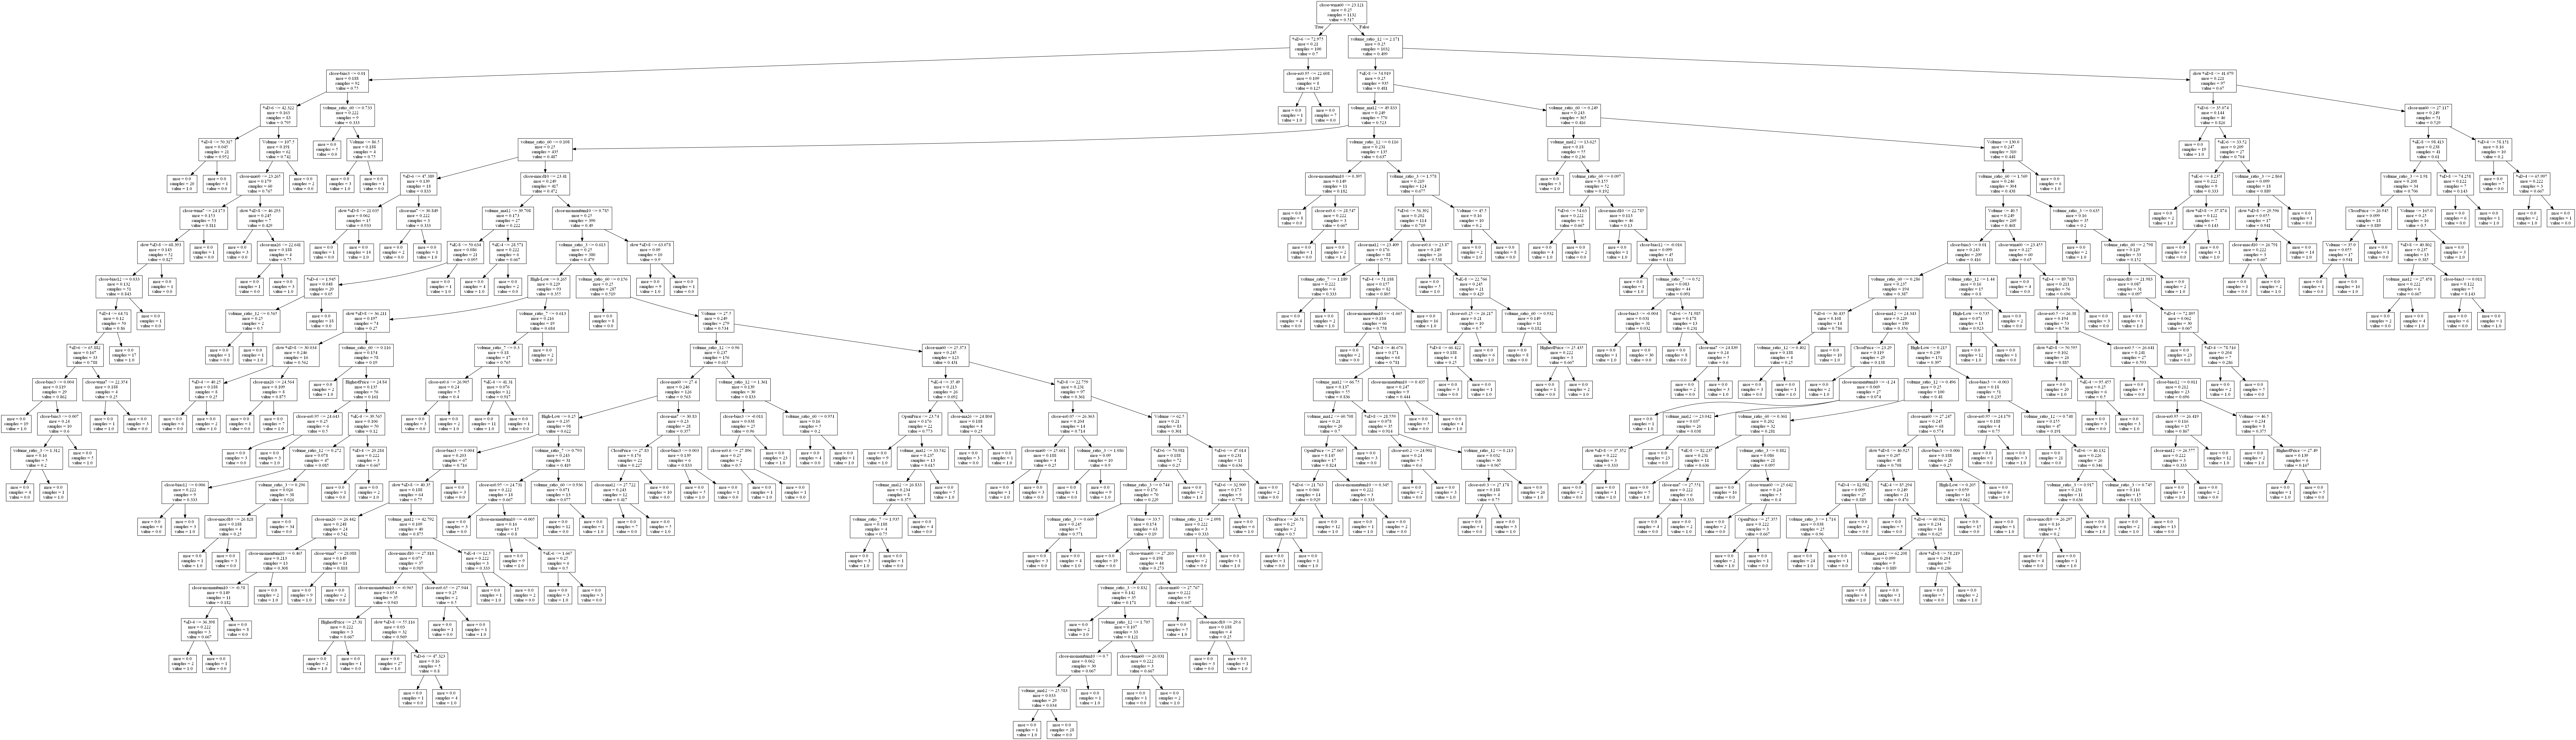

In [10]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,export_graphviz
import pydotplus
from IPython.display import Image, display
import IPython
%matplotlib inline
import os
import sys
def conda_fix(graph):
        path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)

forest=DecisionTreeRegressor(criterion='mse', max_depth=None, random_state=None)
forest.fit(train_X, train_Y)
reg_dot_data = export_graphviz(forest,out_file=None,feature_names=ETF_X.columns)
reg_graph = pydotplus.graph_from_dot_data(reg_dot_data)
graph = pydotplus.graph_from_dot_data(reg_dot_data)
conda_fix(graph)
Image(graph.create_png())
#reg_graph.write_png(graph.create_png())

# 用最好的染色體再跑一次model

In [9]:

#def random_forest_model(filename,chromsome):
chromsome=x_best
# 載入資料
ETF_train = pd.read_csv(filename)
col_list=list(ETF_train.columns)

n_estimators_c=chromsome[len(col_list)-1]
criterion_c=chromsome[len(col_list)+0]
max_features_c=chromsome[len(col_list)+1]
traindata_rate=chromsome[len(col_list)+2]

# 建立訓練與測試資料
x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
ETF_X = pd.DataFrame(x_tmp).T
ETF_Y = ETF_train["Y"]

train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

# 建立 random forest 模型
forest = ensemble.RandomForestClassifier(n_estimators = n_estimators_c,criterion=criterion_c,max_features=max_features_c)
forest.fit(train_X, train_Y)
forest_fit = forest.fit(train_X, train_Y)

# 預測
test_y_predicted = forest.predict(test_X)
print(test_y_predicted)
# 績效
accuracy = metrics.accuracy_score(test_Y, test_y_predicted)
print(accuracy)
    #return accuracy

[1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0
 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
0.563492063492
